<a href="https://colab.research.google.com/github/mshilpaa/EVA4/blob/master/Session%2010/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U git+https://github.com/albu/albumentations

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-yc73l3od
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-yc73l3od
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=65100 sha256=1998949ef806cc5885b5b48974031d4faaf3ea646f204574dcccde93bac1e08e
  Stored in directory: /tmp/pip-ephem-wheel-cache-axot_v0c/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 0.4.5
    Uninstalling albumentations-0.4.5:
      Successfully uninstalled albumentations-0.4.5


In [2]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [0]:
# import autoreload
# %load_ext autoreload
# %autoreload

In [0]:
import sys
folder = '/content/gdrive/My Drive/Colab Notebooks/eva_files'
sys.path.append(folder)

In [6]:
%matplotlib inline
import torch
import data_loading
import show_images
import dnn_architecture
import train_and_test
import evaluate
import gradcam
import lr_finder

  pip install torch-lr-finder -v --global-option="amp"


In [7]:
classes, trainloader, testloader = data_loading.load()

Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


shape: torch.Size([128, 3, 32, 32])
  cat truck truck   cat


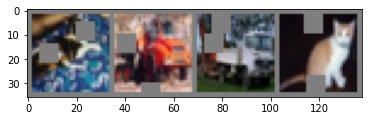

In [8]:
show_images.show_random_images(trainloader, classes)

In [9]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = dnn_architecture.Resnet18().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

In [10]:
import torch.nn as nn
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9,weight_decay=0.0005)
lr_finder = lr_finder.LRFinder(model, optimizer, criterion, device="cuda")
# 1 iteration for each batch
lr_finder.range_test(trainloader, start_lr=0.000001,end_lr=10, num_iter=400, step_mode="exp")


Learning rate search finished. See the graph with {finder_name}.plot()


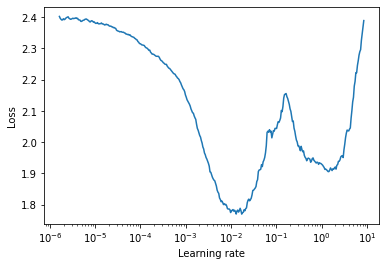

In [11]:
lr_finder.plot()

In [12]:
loss = lr_finder.history['loss']
print('index=',loss.index(min(loss)),'min loss= ',min(loss))
print('lr = ',lr_finder.history['lr'][loss.index(min(loss))])

index= 240 min loss=  1.7700655326824484
lr =  0.017179083871575875


In [0]:
lr_finder.reset()

In [0]:
lr = 0.017179083871575875
# lr = lr_finder.history['lr'][loss.index(min(loss))]
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9,weight_decay=0.0005)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=False, 
                              threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0.0001, eps=1e-08)

In [15]:
EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1, 'LR:',optimizer.param_groups[0]['lr'])
    train_and_test.train(model, device, trainloader, optimizer, criterion, epoch)
    train_and_test.test(model, device, criterion, testloader)
    scheduler.step(train_and_test.test_losses[-1])

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1 LR: 0.017179083871575875


Loss=1.0510631799697876 Batch_id=390 Accuracy=48.96: 100%|██████████| 391/391 [01:04<00:00,  6.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0115, Accuracy: 5532/10000 (55.32%)

EPOCH: 2 LR: 0.017179083871575875


Loss=0.8201020956039429 Batch_id=390 Accuracy=67.14: 100%|██████████| 391/391 [01:04<00:00,  6.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Accuracy: 6910/10000 (69.10%)

EPOCH: 3 LR: 0.017179083871575875


Loss=0.8600339889526367 Batch_id=390 Accuracy=74.59: 100%|██████████| 391/391 [01:04<00:00,  6.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 7742/10000 (77.42%)

EPOCH: 4 LR: 0.017179083871575875


Loss=0.5721256732940674 Batch_id=390 Accuracy=78.61: 100%|██████████| 391/391 [01:05<00:00,  5.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8039/10000 (80.39%)

EPOCH: 5 LR: 0.017179083871575875


Loss=0.5918905735015869 Batch_id=390 Accuracy=81.59: 100%|██████████| 391/391 [01:05<00:00,  6.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 7818/10000 (78.18%)

EPOCH: 6 LR: 0.017179083871575875


Loss=0.3431490361690521 Batch_id=390 Accuracy=83.55: 100%|██████████| 391/391 [01:05<00:00,  5.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 8040/10000 (80.40%)

EPOCH: 7 LR: 0.017179083871575875


Loss=0.4171218276023865 Batch_id=390 Accuracy=84.67: 100%|██████████| 391/391 [01:05<00:00,  5.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 8028/10000 (80.28%)

EPOCH: 8 LR: 0.0017179083871575877


Loss=0.24868178367614746 Batch_id=390 Accuracy=90.06: 100%|██████████| 391/391 [01:05<00:00,  6.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8794/10000 (87.94%)

EPOCH: 9 LR: 0.0017179083871575877


Loss=0.1751561313867569 Batch_id=390 Accuracy=91.66: 100%|██████████| 391/391 [01:05<00:00,  5.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8839/10000 (88.39%)

EPOCH: 10 LR: 0.0017179083871575877


Loss=0.3161076009273529 Batch_id=390 Accuracy=92.24: 100%|██████████| 391/391 [01:05<00:00,  5.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8855/10000 (88.55%)

EPOCH: 11 LR: 0.0017179083871575877


Loss=0.1175425797700882 Batch_id=390 Accuracy=92.94: 100%|██████████| 391/391 [01:04<00:00,  6.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8859/10000 (88.59%)

EPOCH: 12 LR: 0.0017179083871575877


Loss=0.18301768600940704 Batch_id=390 Accuracy=93.55: 100%|██████████| 391/391 [01:04<00:00,  6.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8894/10000 (88.94%)

EPOCH: 13 LR: 0.0017179083871575877


Loss=0.201382115483284 Batch_id=390 Accuracy=94.04: 100%|██████████| 391/391 [01:04<00:00,  6.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8862/10000 (88.62%)

EPOCH: 14 LR: 0.0017179083871575877


Loss=0.1495133340358734 Batch_id=390 Accuracy=94.59: 100%|██████████| 391/391 [01:05<00:00,  5.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8866/10000 (88.66%)

EPOCH: 15 LR: 0.00017179083871575877


Loss=0.09749474376440048 Batch_id=390 Accuracy=95.27: 100%|██████████| 391/391 [01:05<00:00,  5.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8903/10000 (89.03%)

EPOCH: 16 LR: 0.00017179083871575877


Loss=0.07378877699375153 Batch_id=390 Accuracy=95.40: 100%|██████████| 391/391 [01:04<00:00,  6.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8914/10000 (89.14%)

EPOCH: 17 LR: 0.00017179083871575877


Loss=0.1046745553612709 Batch_id=390 Accuracy=95.71: 100%|██████████| 391/391 [01:05<00:00,  6.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8920/10000 (89.20%)

EPOCH: 18 LR: 0.00017179083871575877


Loss=0.0877847746014595 Batch_id=390 Accuracy=95.57: 100%|██████████| 391/391 [01:05<00:00,  5.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8925/10000 (89.25%)

EPOCH: 19 LR: 0.0001


Loss=0.06836742907762527 Batch_id=390 Accuracy=95.66: 100%|██████████| 391/391 [01:05<00:00,  6.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8916/10000 (89.16%)

EPOCH: 20 LR: 0.0001


Loss=0.11965461075305939 Batch_id=390 Accuracy=95.70: 100%|██████████| 391/391 [01:05<00:00,  6.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8920/10000 (89.20%)

EPOCH: 21 LR: 0.0001


Loss=0.23225708305835724 Batch_id=390 Accuracy=95.87: 100%|██████████| 391/391 [01:05<00:00,  6.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8936/10000 (89.36%)

EPOCH: 22 LR: 0.0001


Loss=0.11868543922901154 Batch_id=390 Accuracy=95.68: 100%|██████████| 391/391 [01:05<00:00,  6.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8920/10000 (89.20%)

EPOCH: 23 LR: 0.0001


Loss=0.14066602289676666 Batch_id=390 Accuracy=95.82: 100%|██████████| 391/391 [01:05<00:00,  6.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8924/10000 (89.24%)

EPOCH: 24 LR: 0.0001


Loss=0.1669805347919464 Batch_id=390 Accuracy=95.92: 100%|██████████| 391/391 [01:05<00:00,  6.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8921/10000 (89.21%)

EPOCH: 25 LR: 0.0001


Loss=0.14039458334445953 Batch_id=390 Accuracy=95.86: 100%|██████████| 391/391 [01:05<00:00,  6.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8918/10000 (89.18%)

EPOCH: 26 LR: 0.0001


Loss=0.13990499079227448 Batch_id=390 Accuracy=95.97: 100%|██████████| 391/391 [01:04<00:00,  6.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8925/10000 (89.25%)

EPOCH: 27 LR: 0.0001


Loss=0.1616528332233429 Batch_id=390 Accuracy=95.93: 100%|██████████| 391/391 [01:05<00:00,  6.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8928/10000 (89.28%)

EPOCH: 28 LR: 0.0001


Loss=0.0973837599158287 Batch_id=390 Accuracy=96.11: 100%|██████████| 391/391 [01:05<00:00,  6.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8916/10000 (89.16%)

EPOCH: 29 LR: 0.0001


Loss=0.08686155080795288 Batch_id=390 Accuracy=96.08: 100%|██████████| 391/391 [01:05<00:00,  5.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8925/10000 (89.25%)

EPOCH: 30 LR: 0.0001


Loss=0.04157669097185135 Batch_id=390 Accuracy=96.17: 100%|██████████| 391/391 [01:05<00:00,  5.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8912/10000 (89.12%)

EPOCH: 31 LR: 0.0001


Loss=0.0938185304403305 Batch_id=390 Accuracy=96.14: 100%|██████████| 391/391 [01:04<00:00,  6.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8912/10000 (89.12%)

EPOCH: 32 LR: 0.0001


Loss=0.08614712953567505 Batch_id=390 Accuracy=96.19: 100%|██████████| 391/391 [01:04<00:00,  6.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8925/10000 (89.25%)

EPOCH: 33 LR: 0.0001


Loss=0.15899452567100525 Batch_id=390 Accuracy=96.14: 100%|██████████| 391/391 [01:05<00:00,  6.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8912/10000 (89.12%)

EPOCH: 34 LR: 0.0001


Loss=0.2365119457244873 Batch_id=390 Accuracy=96.36: 100%|██████████| 391/391 [01:05<00:00,  6.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8932/10000 (89.32%)

EPOCH: 35 LR: 0.0001


Loss=0.1539423167705536 Batch_id=390 Accuracy=96.23: 100%|██████████| 391/391 [01:05<00:00,  5.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8927/10000 (89.27%)

EPOCH: 36 LR: 0.0001


Loss=0.055686552077531815 Batch_id=390 Accuracy=96.34: 100%|██████████| 391/391 [01:05<00:00,  6.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8931/10000 (89.31%)

EPOCH: 37 LR: 0.0001


Loss=0.09905791282653809 Batch_id=390 Accuracy=96.36: 100%|██████████| 391/391 [01:05<00:00,  6.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8923/10000 (89.23%)

EPOCH: 38 LR: 0.0001


Loss=0.07818665355443954 Batch_id=390 Accuracy=96.33: 100%|██████████| 391/391 [01:05<00:00,  5.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8910/10000 (89.10%)

EPOCH: 39 LR: 0.0001


Loss=0.08831968158483505 Batch_id=390 Accuracy=96.46: 100%|██████████| 391/391 [01:05<00:00,  5.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8912/10000 (89.12%)

EPOCH: 40 LR: 0.0001


Loss=0.09999684989452362 Batch_id=390 Accuracy=96.52: 100%|██████████| 391/391 [01:05<00:00,  5.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8929/10000 (89.29%)

EPOCH: 41 LR: 0.0001


Loss=0.1010054349899292 Batch_id=390 Accuracy=96.58: 100%|██████████| 391/391 [01:05<00:00,  6.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8915/10000 (89.15%)

EPOCH: 42 LR: 0.0001


Loss=0.12644842267036438 Batch_id=390 Accuracy=96.56: 100%|██████████| 391/391 [01:05<00:00,  6.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8915/10000 (89.15%)

EPOCH: 43 LR: 0.0001


Loss=0.057783324271440506 Batch_id=390 Accuracy=96.60: 100%|██████████| 391/391 [01:05<00:00,  5.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8927/10000 (89.27%)

EPOCH: 44 LR: 0.0001


Loss=0.165959432721138 Batch_id=390 Accuracy=96.63: 100%|██████████| 391/391 [01:05<00:00,  6.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8905/10000 (89.05%)

EPOCH: 45 LR: 0.0001


Loss=0.07400991767644882 Batch_id=390 Accuracy=96.52: 100%|██████████| 391/391 [01:05<00:00,  6.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8936/10000 (89.36%)

EPOCH: 46 LR: 0.0001


Loss=0.07535212486982346 Batch_id=390 Accuracy=96.62: 100%|██████████| 391/391 [01:04<00:00,  6.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8937/10000 (89.37%)

EPOCH: 47 LR: 0.0001


Loss=0.0830405205488205 Batch_id=390 Accuracy=96.68: 100%|██████████| 391/391 [01:05<00:00,  6.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8915/10000 (89.15%)

EPOCH: 48 LR: 0.0001


Loss=0.15678100287914276 Batch_id=390 Accuracy=96.74: 100%|██████████| 391/391 [01:05<00:00,  5.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8927/10000 (89.27%)

EPOCH: 49 LR: 0.0001


Loss=0.125912606716156 Batch_id=390 Accuracy=96.67: 100%|██████████| 391/391 [01:05<00:00,  6.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8926/10000 (89.26%)

EPOCH: 50 LR: 0.0001


Loss=0.12787194550037384 Batch_id=390 Accuracy=96.72: 100%|██████████| 391/391 [01:05<00:00,  6.00it/s]



Test set: Average loss: 0.0028, Accuracy: 8916/10000 (89.16%)



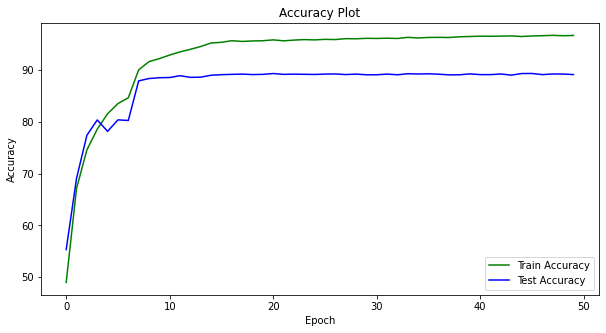

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
ax.plot(train_and_test.train_acc_epoch_end,color = 'g',label="Train Accuracy")
ax.plot(train_and_test.test_acc,color = 'b',label="Test Accuracy")
ax.set(title="Accuracy Plot", xlabel="Epoch", ylabel="Accuracy")
ax.legend()
plt.show()

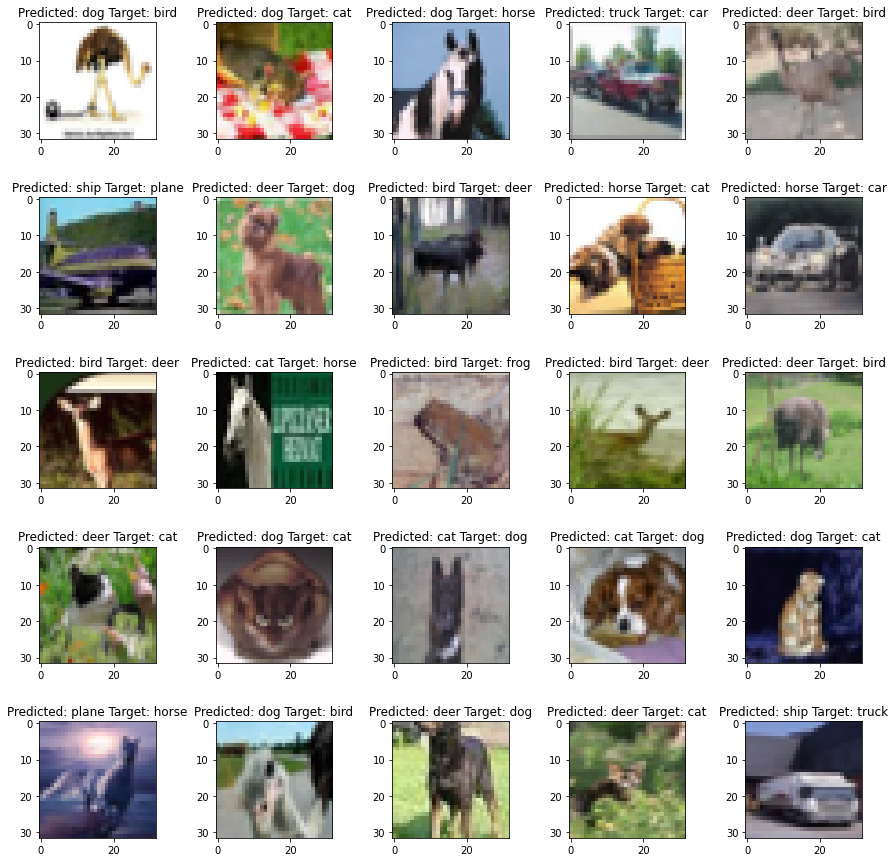

In [17]:
misclassify = show_images.show_misclassified_images(model, device, testloader,classes,num=25)

GroundTruth:    car   dog   cat   dog   cat
Predicted:    car   dog   dog   dog   cat


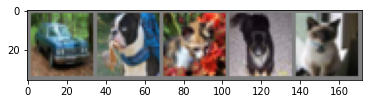

In [18]:
evaluate.show_predicted_actual(model, device, testloader, classes)

In [19]:
evaluate.evaluate_accuracy(model, device, testloader)

Accuracy of the network on the 10000 test images: 89 %


In [20]:
evaluate.evaluate_classwise_accuracy(model, device, classes, testloader)

Accuracy of plane : 91 %
Accuracy of   car : 90 %
Accuracy of  bird : 92 %
Accuracy of   cat : 77 %
Accuracy of  deer : 91 %
Accuracy of   dog : 77 %
Accuracy of  frog : 91 %
Accuracy of horse : 97 %
Accuracy of  ship : 84 %
Accuracy of truck : 93 %


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:130: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


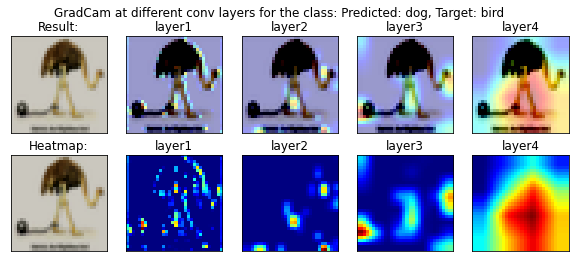

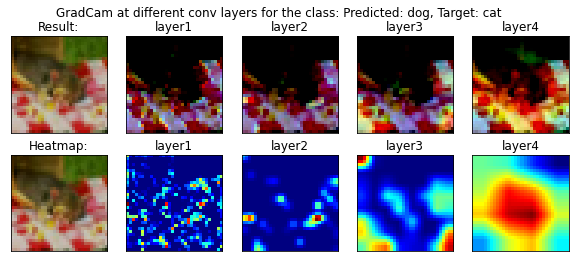

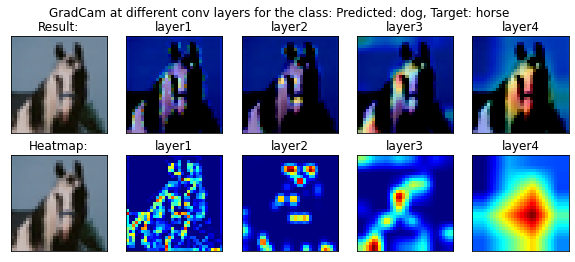

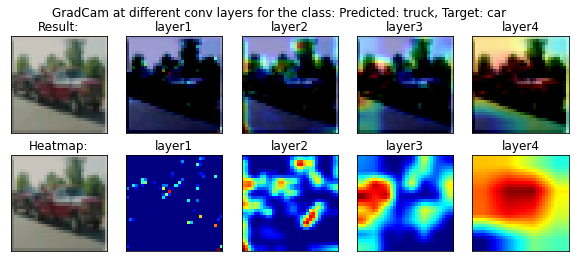

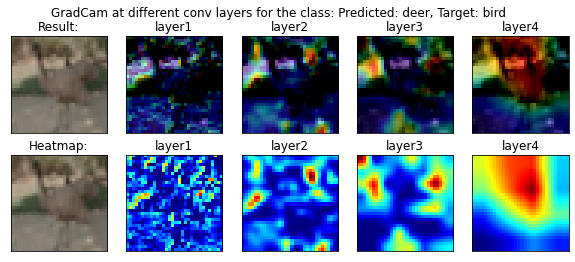

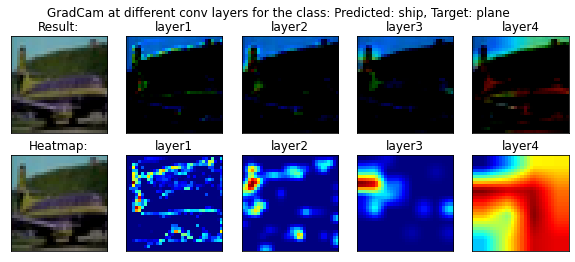

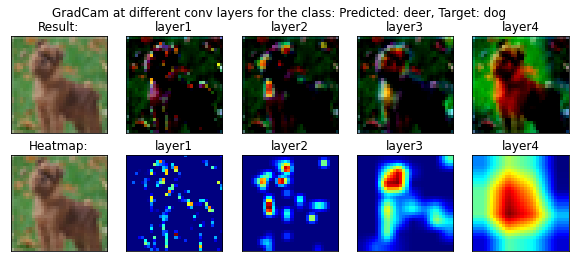

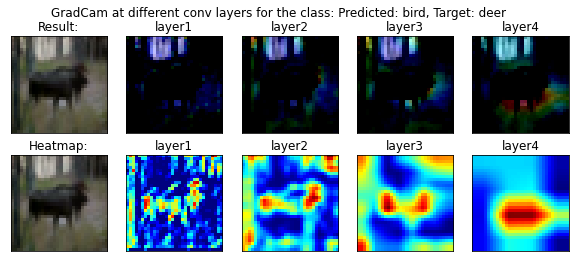

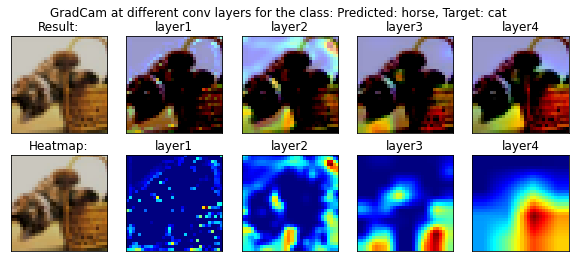

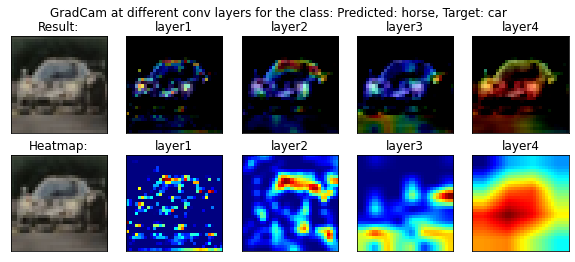

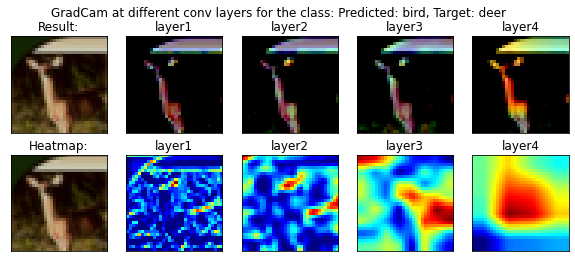

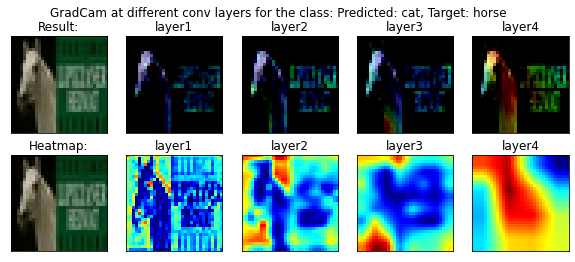

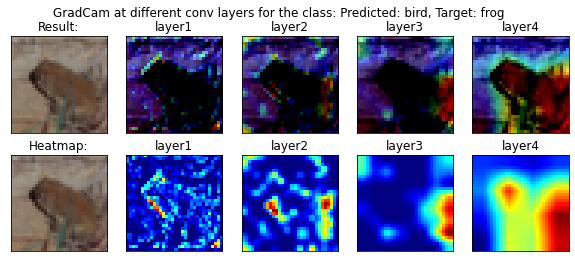

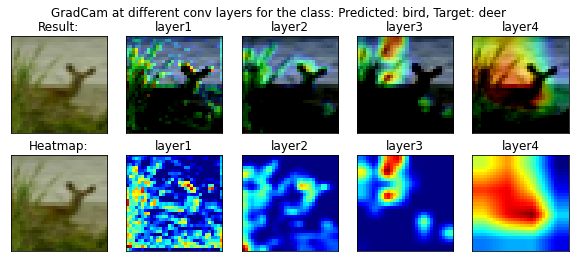

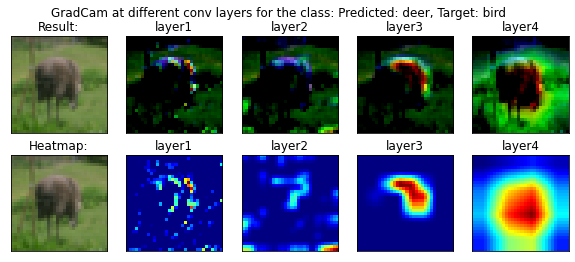

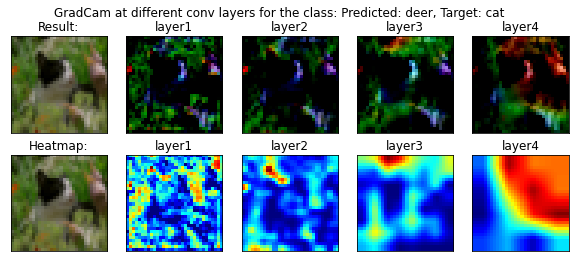

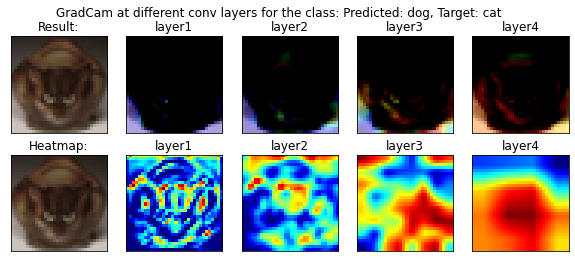

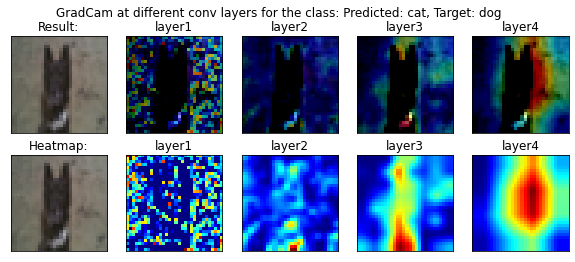

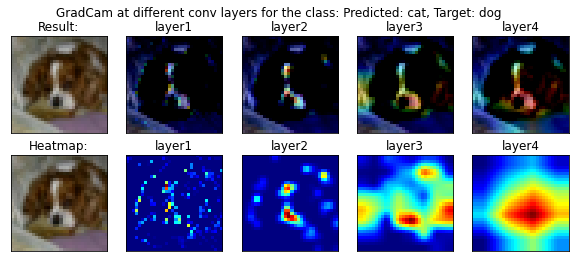

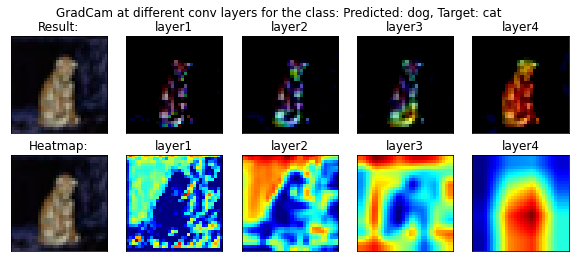

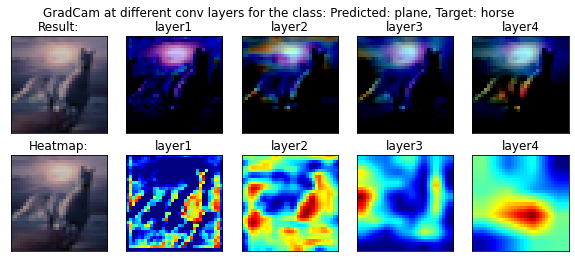

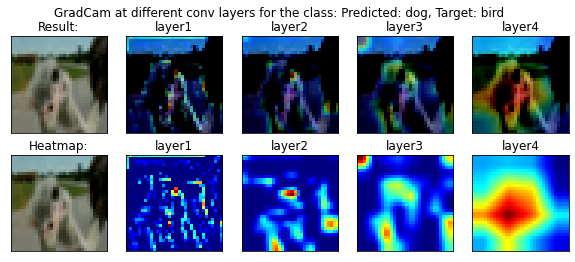

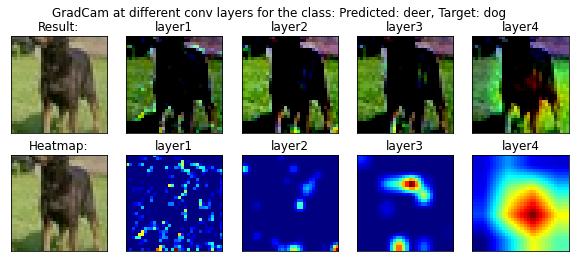

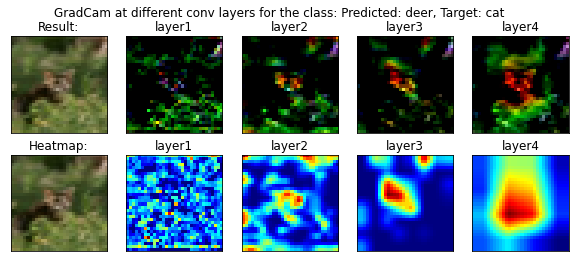

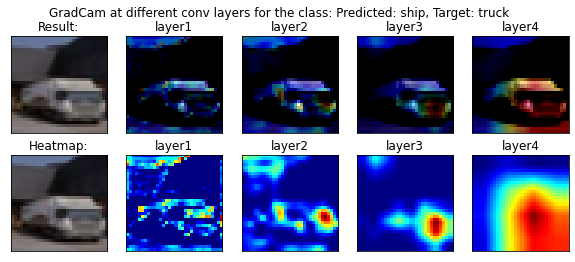

In [24]:
images=[]

for i in range(25):
  images.append(misclassify[0][i]*2-0.5)

target_layers = ["layer1","layer2","layer3","layer4"]
gradcam = gradcam.VisualizeCam(model,classes, target_layers)
gradcam(torch.stack(images), target_layers,target_class=misclassify[2],pred=misclassify[1],num=25,name='misclassify')